# Installing libraries

In [1]:
!pip install aif360
!pip install fairlearn
!pip install BlackBoxAuditing
!pip install adversarial-robustness-toolbox 
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394756 sha256=59be2c72b5a34f5fd9f224b445adcc11c250f5f8486bb290dbf2eaba65d214df
  Stored in directory: /root/.cache/pip/wheels/c0/4f/b1/80e1b0790df07536470758fe0a4f9ff8fa942fd9fe30bbb192
Successfully built BlackBoxAuditing
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 105.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into accou

# Pre-processing steps

In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv('/kaggle/input/case-combined/merged_subjects_data.csv')
data

,time,valence,arousal,video_x,Emotion,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,video_y,SUBJECT,AGE,GENDER,EMOTION,video_name,vid_emotion
0,1061504,-1276.0,6252.0,8.0,Frustrated or Impatient,0.76062,35.053549,4.384464,27.174558,28.863552,7.86300,6.13825,5.31675,8.0,1,30-34,F,scary,Mama (2008),scary-2
1,1061554,-1276.0,6252.0,8.0,Frustrated or Impatient,0.79018,35.005141,4.360800,27.193884,28.849530,7.94525,5.76850,5.15250,8.0,1,30-34,F,scary,Mama (2008),scary-2
2,1061604,-1276.0,6268.0,8.0,Frustrated or Impatient,0.80990,35.809029,4.380504,27.213270,28.860030,8.06850,5.72750,5.02950,8.0,1,30-34,F,scary,Mama (2008),scary-2
3,1061654,-1276.0,6268.0,8.0,Frustrated or Impatient,0.83946,37.368456,4.384464,27.281031,28.863552,7.37025,6.09725,5.31675,8.0,1,30-34,F,scary,Mama (2008),scary-2
4,1061704,-1276.0,6288.0,8.0,Frustrated or Impatient,0.79018,37.145698,4.356864,27.271309,28.863552,7.65775,5.89175,5.11150,8.0,1,30-34,F,scary,Mama (2008),scary-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196278,2231442,0.0,0.0,7.0,Neutral,1.05632,37.949645,37.403472,46.155954,29.852173,5.39900,7.53450,5.89175,7.0,29,25-29,M,scary,Shutter (2004),scary-1
196279,2231492,0.0,0.0,7.0,Neutral,0.81318,37.542807,37.419240,46.223715,29.852173,5.64550,7.98625,5.85075,7.0,29,25-29,M,scary,Shutter (2004),scary-1
196280,2231542,0.0,0.0,7.0,Neutral,0.82632,36.961677,37.320672,46.301140,29.845152,5.56325,7.41125,5.72750,7.0,29,25-29,M,scary,Shutter (2004),scary-1
196281,2231592,0.0,0.0,7.0,Neutral,0.83290,36.516101,37.407408,46.397951,29.862694,5.76850,7.57550,5.80975,12.0,29,25-29,M,scary,Shutter (2004),scary-1


In [3]:
data['Emotion'].unique()

array(['Frustrated or Impatient', 'Tensed or Annoyed',
       'Distressed or Defiant', 'Neutral', 'Confident or Attentive',
       'Passionate or Amused', 'Pleased or Glad', 'Delighted or Happy',
       'Worried or Apathetic', 'Frustrated or Discontented',
       'Aroused or Astonished', 'Miserable or Sad', 'Anxious or Dejected',
       'Tired or Bored', 'Polite or Sleepy', 'Excited or Adventurous'],
      dtype=object)

In [4]:
# Define positive and negative emotions
positive_emotions = [
    'Confident or Attentive', 'Passionate or Amused', 'Pleased or Glad', 
    'Delighted or Happy', 'Excited or Adventurous', 'Polite or Sleepy', 
    'Neutral', 'Aroused or Astonished'
]

# Add a new column 'Emotion_Type' to classify emotions as Positive or Negative
data['Emotion_Type'] = data['Emotion'].apply(
    lambda x: 'Positive' if x in positive_emotions else 'Negative'
)
# Define the columns to retain
columns_to_keep = [
    'ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_coru', 'emg_trap', 'emg_zygo',  # 8 physio features
    'Emotion', 'AGE', 'GENDER', 'Emotion_Type'  # Other required columns
]

# Create a new DataFrame retaining only the specified columns
data = data[columns_to_keep]

In [5]:
data

,ecg,bvp,gsr,rsp,skt,emg_coru,emg_trap,emg_zygo,Emotion,AGE,GENDER,Emotion_Type
0,0.76062,35.053549,4.384464,27.174558,28.863552,6.13825,5.31675,7.86300,Frustrated or Impatient,30-34,F,Negative
1,0.79018,35.005141,4.360800,27.193884,28.849530,5.76850,5.15250,7.94525,Frustrated or Impatient,30-34,F,Negative
2,0.80990,35.809029,4.380504,27.213270,28.860030,5.72750,5.02950,8.06850,Frustrated or Impatient,30-34,F,Negative
3,0.83946,37.368456,4.384464,27.281031,28.863552,6.09725,5.31675,7.37025,Frustrated or Impatient,30-34,F,Negative
4,0.79018,37.145698,4.356864,27.271309,28.863552,5.89175,5.11150,7.65775,Frustrated or Impatient,30-34,F,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...
196278,1.05632,37.949645,37.403472,46.155954,29.852173,7.53450,5.89175,5.39900,Neutral,25-29,M,Positive
196279,0.81318,37.542807,37.419240,46.223715,29.852173,7.98625,5.85075,5.64550,Neutral,25-29,M,Positive
196280,0.82632,36.961677,37.320672,46.301140,29.845152,7.41125,5.72750,5.56325,Neutral,25-29,M,Positive
196281,0.83290,36.516101,37.407408,46.397951,29.862694,7.57550,5.80975,5.76850,Neutral,25-29,M,Positive


Gender and Age Distribution (Heatmap Data):
AGE     20-24  25-29  30-34  35-39
GENDER                            
F       47654  32822  13625      0
M       20440  61304   6812  13626
Total Instances: 196283


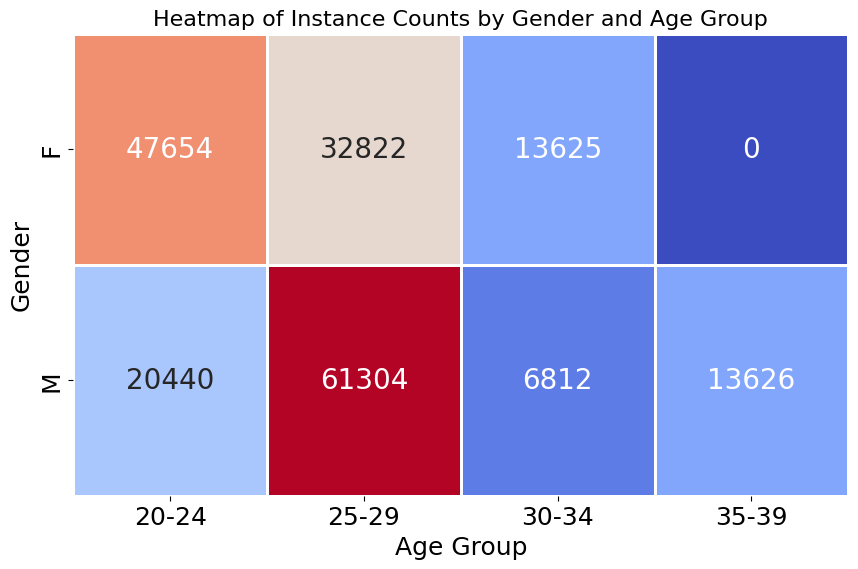


Emotion Type Counts and Percentages:
Emotion
Neutral                       108843
Confident or Attentive         18418
Passionate or Amused           17212
Frustrated or Impatient        16325
Distressed or Defiant          11175
Worried or Apathetic            6601
Tensed or Annoyed               4845
Delighted or Happy              4296
Pleased or Glad                 2963
Frustrated or Discontented      1823
Tired or Bored                  1195
Aroused or Astonished           1152
Polite or Sleepy                 982
Miserable or Sad                 247
Anxious or Dejected              157
Excited or Adventurous            49
Name: count, dtype: int64
Emotion
Neutral                       55.452077
Confident or Attentive         9.383390
Passionate or Amused           8.768971
Frustrated or Impatient        8.317073
Distressed or Defiant          5.693310
Worried or Apathetic           3.363001
Tensed or Annoyed              2.468375
Delighted or Happy             2.188677
Pleased 

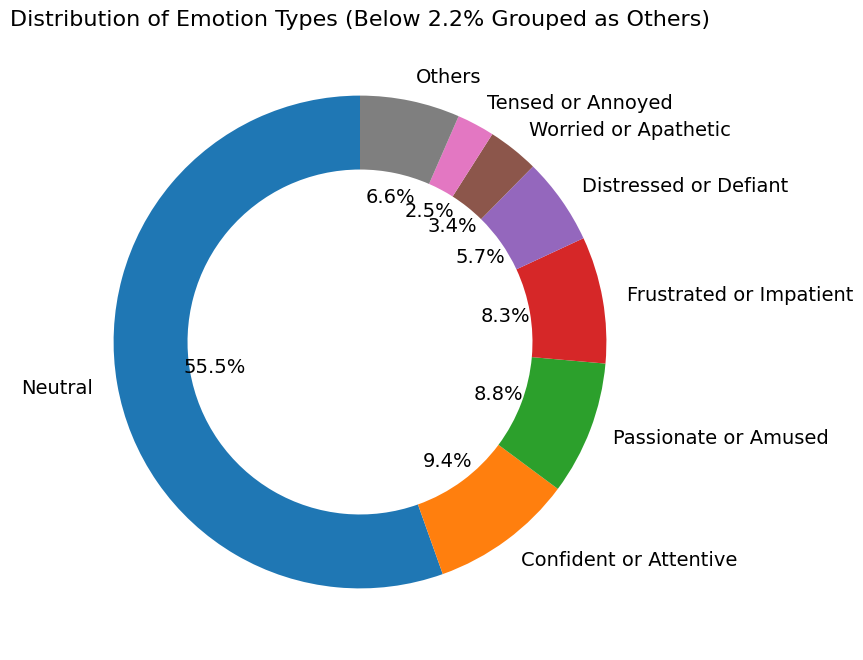


Number of Instances with 'Neutral': 108843

Emotion Type Counts (Excluding Neutral):
Emotion
Confident or Attentive        18418
Passionate or Amused          17212
Frustrated or Impatient       16325
Distressed or Defiant         11175
Worried or Apathetic           6601
Tensed or Annoyed              4845
Delighted or Happy             4296
Pleased or Glad                2963
Frustrated or Discontented     1823
Tired or Bored                 1195
Aroused or Astonished          1152
Polite or Sleepy                982
Miserable or Sad                247
Anxious or Dejected             157
Excited or Adventurous           49
Name: count, dtype: int64
Total Instances (Excluding Neutral): 87440
Emotion Type Percentages (Excluding Neutral):
Emotion
Confident or Attentive        21.063586
Passionate or Amused          19.684355
Frustrated or Impatient       18.669945
Distressed or Defiant         12.780192
Worried or Apathetic           7.549177
Tensed or Annoyed              5.540942
Del

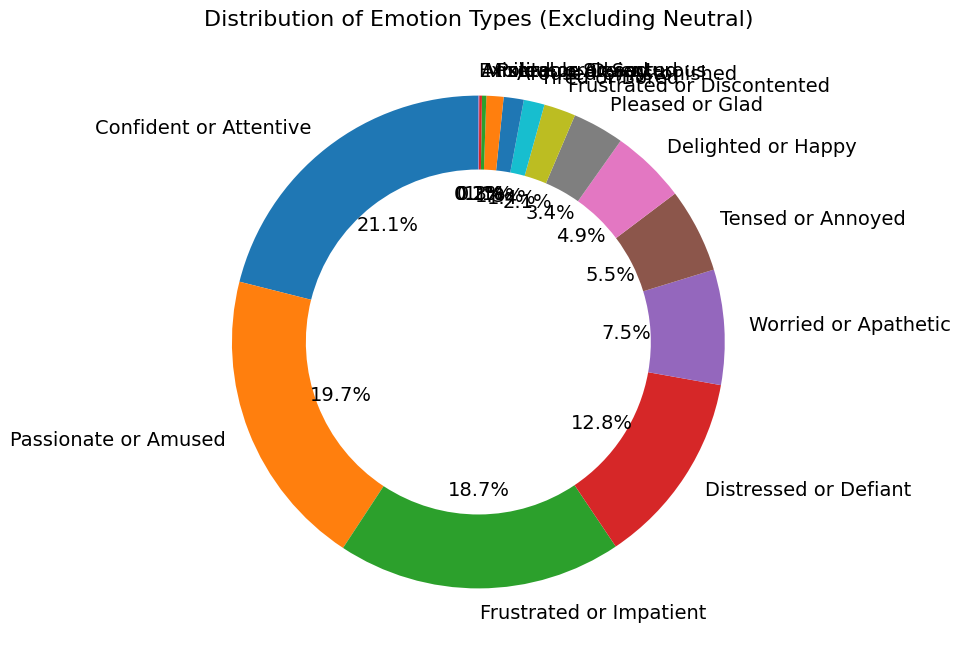


Age Group Distribution:
AGE
25-29    94126
20-24    68094
30-34    20437
35-39    13626
Name: count, dtype: int64
Total Instances in Age Groups: 196283


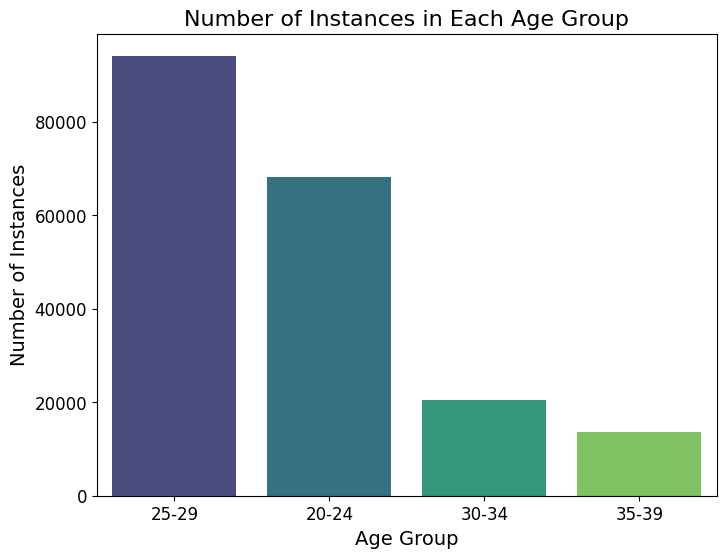


Gender Distribution:
GENDER
M    102182
F     94101
Name: count, dtype: int64
Total Instances in Gender Classes: 196283


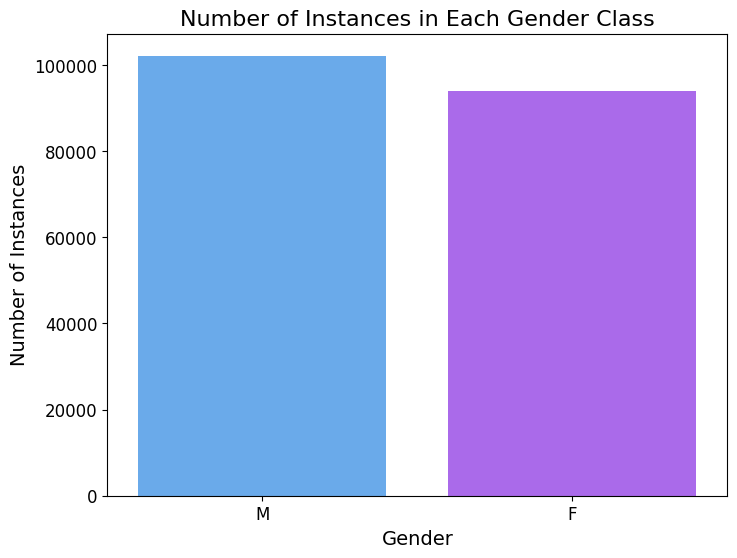

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example DataFrame (replace with your dataset)
# data = pd.read_csv("your_data.csv")

# 1. Heatmap for Gender and Age Distribution
plt.figure(figsize=(10, 6))

# Grouping data by Gender and Age and calculating the count
heatmap_data = data.groupby(['GENDER', 'AGE']).size().unstack(fill_value=0)

# Print the heatmap data and total count
print("Gender and Age Distribution (Heatmap Data):")
print(heatmap_data)
print(f"Total Instances: {heatmap_data.sum().sum()}")  # Total instances in the heatmap data

# Create the heatmap
sns.heatmap(
    heatmap_data, annot=True, cmap='coolwarm', fmt='d', linewidths=1, cbar=False,
    annot_kws={"size": 20}  # Adjust text size
)
plt.title('Heatmap of Instance Counts by Gender and Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=18)
plt.ylabel('Gender', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# 2. Donut Chart for Emotion_Type Distribution (with threshold)
percentage_threshold = 2.2  # Set the percentage threshold (e.g., 5%)
emotion_type_counts = data['Emotion'].value_counts()

# Calculate percentages
total_count = emotion_type_counts.sum()
emotion_type_percentages = (emotion_type_counts / total_count) * 100

# Print the emotion type counts, percentages, and total instances
print("\nEmotion Type Counts and Percentages:")
print(emotion_type_counts)
print(emotion_type_percentages)
print(f"Total Instances: {total_count}")  # Total instances in emotion type data

# Group smaller categories
emotion_type_counts_filtered = emotion_type_counts[emotion_type_percentages >= percentage_threshold]
others_count = emotion_type_counts[emotion_type_percentages < percentage_threshold].sum()
if others_count > 0:
    emotion_type_counts_filtered["Others"] = others_count

# Plot the initial donut chart
plt.figure(figsize=(8, 8))
plt.pie(
    emotion_type_counts_filtered, labels=emotion_type_counts_filtered.index, autopct='%1.1f%%', 
    startangle=90, textprops={'fontsize': 14}, wedgeprops={'width': 0.3}
)
plt.title(f'Distribution of Emotion Types (Below {percentage_threshold}% Grouped as Others)', fontsize=16)
plt.show()

# 3. Remove 'Neutral' instances and plot donut chart again
# Print the count of 'Neutral' instances before excluding
neutral_count = data[data['Emotion'] == 'Neutral'].shape[0]
print(f"\nNumber of Instances with 'Neutral': {neutral_count}")

# Remove 'Neutral' instances
data_no_neutral = data[data['Emotion'] != 'Neutral']

# Recalculate emotion type counts and percentages for non-neutral instances
emotion_type_counts_no_neutral = data_no_neutral['Emotion'].value_counts()

# Print the filtered emotion type counts and total instances
print("\nEmotion Type Counts (Excluding Neutral):")
print(emotion_type_counts_no_neutral)
print(f"Total Instances (Excluding Neutral): {emotion_type_counts_no_neutral.sum()}")  # Total instances excluding 'Neutral'

# Calculate percentages for non-neutral instances
emotion_type_percentages_no_neutral = (emotion_type_counts_no_neutral / emotion_type_counts_no_neutral.sum()) * 100
print("Emotion Type Percentages (Excluding Neutral):")
print(emotion_type_percentages_no_neutral)

# Plot the donut chart again without Neutral instances
plt.figure(figsize=(8, 8))
plt.pie(
    emotion_type_counts_no_neutral, labels=emotion_type_counts_no_neutral.index, autopct='%1.1f%%', 
    startangle=90, textprops={'fontsize': 14}, wedgeprops={'width': 0.3}
)
plt.title('Distribution of Emotion Types (Excluding Neutral)', fontsize=16)
plt.show()

# 4. Bar Plot for Age Group Distribution
plt.figure(figsize=(8, 6))

# Count the instances for each age group
age_counts = data['AGE'].value_counts()

# Print the age group distribution and total instances
print("\nAge Group Distribution:")
print(age_counts)
print(f"Total Instances in Age Groups: {age_counts.sum()}")  # Total instances in age groups

# Create the bar plot
sns.barplot(
    x=age_counts.index,
    y=age_counts.values,
    palette='viridis'
)
plt.title('Number of Instances in Each Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 5. Bar Plot for Gender Distribution
plt.figure(figsize=(8, 6))

# Count the instances for each gender
gender_counts = data['GENDER'].value_counts()

# Print the gender distribution and total instances
print("\nGender Distribution:")
print(gender_counts)
print(f"Total Instances in Gender Classes: {gender_counts.sum()}")  # Total instances in gender classes

# Create the bar plot
sns.barplot(
    x=gender_counts.index,
    y=gender_counts.values,
    palette='cool'
)
plt.title('Number of Instances in Each Gender Class', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


Missing values before cleaning:
ecg             1
bvp             1
gsr             1
rsp             1
skt             1
emg_coru        1
emg_trap        1
emg_zygo        1
Emotion         0
AGE             0
GENDER          0
Emotion_Type    0
dtype: int64

Missing values after cleaning:
ecg             1
bvp             1
gsr             1
rsp             1
skt             1
emg_coru        1
emg_trap        1
emg_zygo        1
Emotion         0
AGE             0
GENDER          0
Emotion_Type    0
dtype: int64
Target size per class: 3629

Old Emotion Class Distribution (excluding neutral):
Emotion
Confident or Attentive        18418
Passionate or Amused          17212
Frustrated or Impatient       16325
Distressed or Defiant         11175
Worried or Apathetic           6601
Tensed or Annoyed              4845
Delighted or Happy             4296
Pleased or Glad                2963
Frustrated or Discontented     1823
Tired or Bored                 1195
Aroused or Astonished        

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



New Emotion Class Distribution (after ADASYN or SMOTE):
Counter({'Confident or Attentive': 18418, 'Passionate or Amused': 17212, 'Frustrated or Impatient': 16325, 'Distressed or Defiant': 11175, 'Worried or Apathetic': 6601, 'Tensed or Annoyed': 4845, 'Delighted or Happy': 4296, 'Frustrated or Discontented': 3794, 'Aroused or Astonished': 3737, 'Polite or Sleepy': 3684, 'Miserable or Sad': 3663, 'Anxious or Dejected': 3639, 'Excited or Adventurous': 3634, 'Neutral': 3629, 'Pleased or Glad': 3629, 'Tired or Bored': 3577})
Total Instances after balancing: 111858
       ecg        bvp        gsr        rsp        skt  emg_coru  emg_trap  \
0  0.80990  36.138391   7.400496  35.063287  24.916064   5.39900  18.49975   
1  0.71462  36.545170  24.456000  37.667035  32.169486   5.48125   5.76850   
2  0.78034  36.690452  31.458024  31.840022  24.176342   6.75425   6.71325   
3  0.79348  36.244935   6.245328  33.572653  22.426978   6.05600  10.45025   
4  0.81976  34.162456  24.972480  33.28228

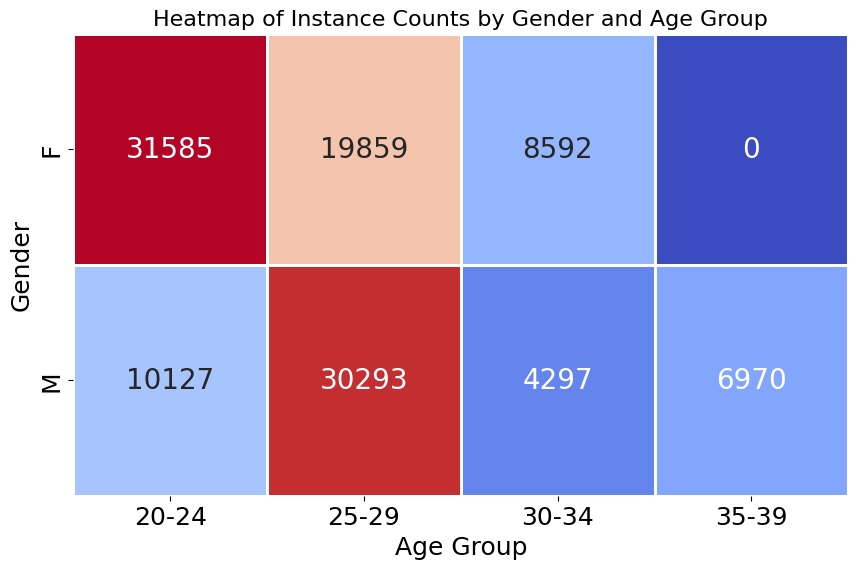


Emotion Distribution Information:
Emotion
Confident or Attentive        18418
Passionate or Amused          17212
Frustrated or Impatient       16325
Distressed or Defiant         11175
Worried or Apathetic           6601
Tensed or Annoyed              4845
Delighted or Happy             4296
Frustrated or Discontented     3794
Aroused or Astonished          3737
Polite or Sleepy               3684
Miserable or Sad               3663
Anxious or Dejected            3639
Excited or Adventurous         3634
Neutral                        3629
Pleased or Glad                3629
Tired or Bored                 3577
Name: count, dtype: int64
Total Instances in Emotion Distribution: 111858
Percentages for each class:
Emotion
Confident or Attentive        16.465519
Passionate or Amused          15.387366
Frustrated or Impatient       14.594396
Distressed or Defiant          9.990345
Worried or Apathetic           5.901232
Tensed or Annoyed              4.331384
Delighted or Happy             

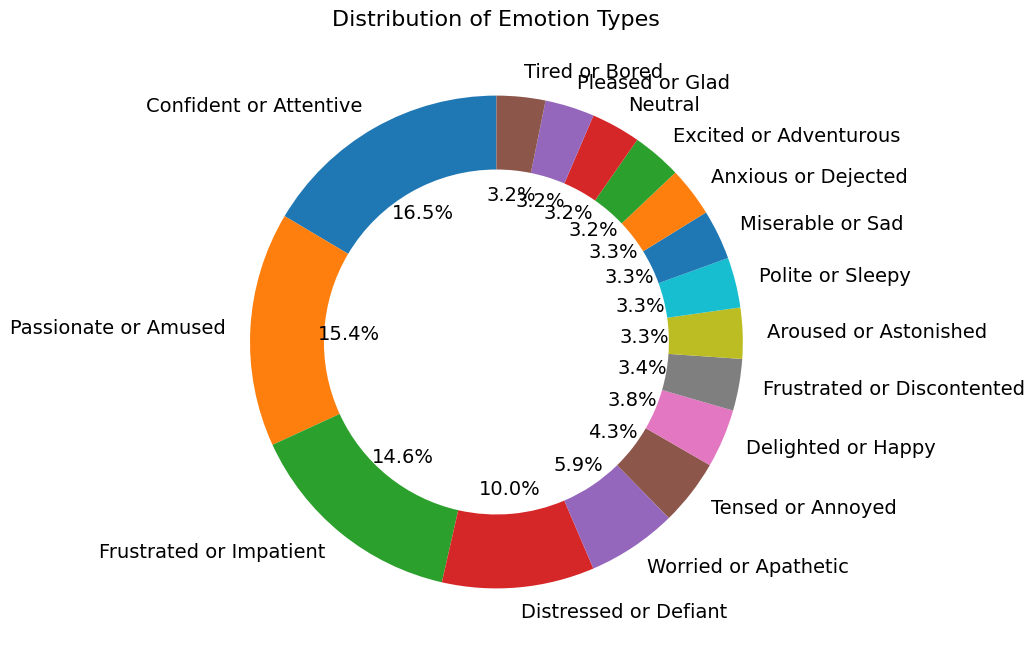


Age Group Distribution Information:
AGE
25-29    50154
20-24    41721
30-34    12889
35-39     6970
Name: count, dtype: int64
Total Instances in Age Group Distribution: 111734

Old vs New Age Group Counts (excluding Neutral):
25-29: Old=94126, New=50154, Difference=-43972
20-24: Old=68094, New=41721, Difference=-26373
30-34: Old=20437, New=12889, Difference=-7548
35-39: Old=13626, New=6970, Difference=-6656


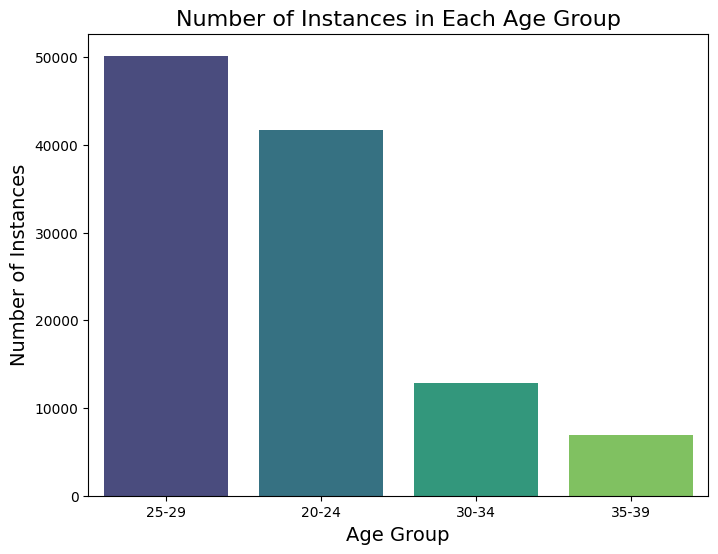


Gender Distribution Information:
GENDER
F    60083
M    51687
Name: count, dtype: int64
Total Instances in Gender Distribution: 111770

Old vs New Gender Class Counts (excluding Neutral):
M: Old=102182, New=51687, Difference=-50495
F: Old=94101, New=60083, Difference=-34018


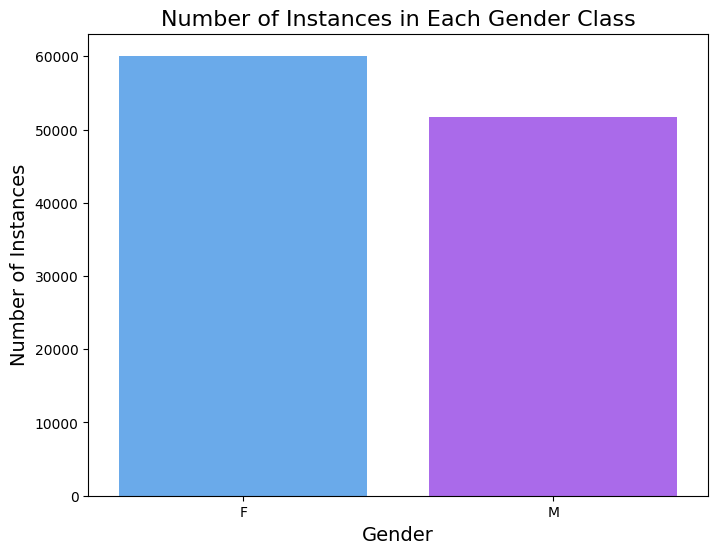

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.impute import SimpleImputer

def clean_data(data):
    """Cleans data by handling missing values in crucial columns."""
    df = data.copy()
    print("Missing values before cleaning:")
    print(df.isnull().sum())
    
    # Drop rows where crucial columns ('Emotion', 'GENDER', 'AGE') have missing values
    crucial_columns = ['Emotion', 'GENDER', 'AGE']
    df = df.dropna(subset=crucial_columns)
    
    print("\nMissing values after cleaning:")
    print(df.isnull().sum())
    return df

def balance_emotion_data(data):
    """Balances the Emotion data using ADASYN or SMOTE."""
    
    # Create a copy of the data to avoid modifying the original data
    df = data.copy()
    
    # Separate neutral emotion data from other emotions
    neutral_mask = df['Emotion'] == 'Neutral'
    df_neutral = df[neutral_mask]
    df_others = df[~neutral_mask]
    
    # Calculate target size for balanced classes
    emotion_counts = df['Emotion'].value_counts()
    target_size = int(np.median(emotion_counts))  # Use median as target size for balancing
    print(f"Target size per class: {target_size}")
    
    # Print old number of instances per class (excluding neutral instances)
    print("\nOld Emotion Class Distribution (excluding neutral):")
    emotion_counts_excluding_neutral = emotion_counts.drop('Neutral', errors='ignore')
    print(emotion_counts_excluding_neutral)
    print(f"Total Instances before balancing: {emotion_counts_excluding_neutral.sum()}")

    # Undersample neutral class to target size
    if len(df_neutral) > target_size:
        neutral_indices = np.random.choice(df_neutral.index, target_size, replace=False)
        df_neutral_balanced = df_neutral.loc[neutral_indices]
    else:
        df_neutral_balanced = df_neutral
    
    # Prepare the data for resampling
    df_combined = pd.concat([df_neutral_balanced, df_others])
    X = df_combined.drop(['Emotion', 'Emotion_Type'], axis=1)
    y = df_combined['Emotion']
    
    # Convert categorical variables to numeric codes
    X['GENDER'] = pd.Categorical(X['GENDER']).codes
    X['AGE'] = pd.Categorical(X['AGE']).codes
    
    # Handle missing values in numeric columns
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    imputer = SimpleImputer(strategy='mean')
    X_imputed = X.copy()
    X_imputed[numeric_columns] = imputer.fit_transform(X[numeric_columns])
    
    # Handle missing values in target variable 'y' if any
    y = y.fillna(y.mode()[0])
    
    # Create sampling strategy dictionary to control synthetic data generation
    sampling_strategy = {}
    for emotion in y.unique():
        count = Counter(y)[emotion]
        if count < target_size:
            sampling_strategy[emotion] = target_size
    
    # Apply ADASYN for resampling
    try:
        adasyn = ADASYN(random_state=42, n_neighbors=5, sampling_strategy=sampling_strategy)
        X_resampled, y_resampled = adasyn.fit_resample(X_imputed, y)
        
        # Print new number of instances after balancing
        print("\nNew Emotion Class Distribution (after ADASYN or SMOTE):")
        print(Counter(y_resampled))
        print(f"Total Instances after balancing: {sum(Counter(y_resampled).values())}")
        
    except ValueError as e:
        print(f"ADASYN failed with error: {str(e)}")
        print("Falling back to SMOTE...")
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
        X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

    # Convert back to DataFrame
    df_resampled = pd.DataFrame(X_resampled, columns=X_imputed.columns)
    df_resampled['Emotion'] = y_resampled
    
    # Convert numeric values back to categorical
    gender_map = {0: 'F', 1: 'M'}
    age_map = {0: '20-24', 1: '25-29', 2: '30-34', 3: '35-39'}
    
    df_resampled['GENDER'] = df_resampled['GENDER'].map(gender_map)
    df_resampled['AGE'] = df_resampled['AGE'].map(age_map)
    print(df_resampled.head())
    
    # Add back 'Emotion_Type'
    emotion_type_map = dict(zip(data['Emotion'], data['Emotion_Type']))
    df_resampled['Emotion_Type'] = df_resampled['Emotion'].map(emotion_type_map)
    
    return df_resampled, df

def create_visualizations(data, old_data):
    """Creates visualizations for the dataset."""
    
    # 1. Heatmap for Gender and Age Distribution
    print("\nHeatmap Information:")
    heatmap_data = data.groupby(['GENDER', 'AGE']).size().unstack(fill_value=0)
    print(heatmap_data)
    print(f"Total Instances in Heatmap: {heatmap_data.sum().sum()}")  # Total instances in the heatmap data
    
    # Print differences (excluding neutral)
    old_heatmap_data = old_data.groupby(['GENDER', 'AGE']).size().unstack(fill_value=0)
    old_heatmap_data_excluding_neutral = old_heatmap_data.drop('Neutral', errors='ignore')
    print("\nOld vs New Heatmap Data (excluding Neutral):")
    print(old_heatmap_data_excluding_neutral.sum().sum(), " (Old) vs", heatmap_data.sum().sum(), " (New)")
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_data, annot=True, cmap='coolwarm', fmt='d', linewidths=1, cbar=False,
        annot_kws={"size": 20}
    )
    plt.title('Heatmap of Instance Counts by Gender and Age Group', fontsize=16)
    plt.xlabel('Age Group', fontsize=18)
    plt.ylabel('Gender', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

    # 2. Donut Chart for Emotion Distribution
    print("\nEmotion Distribution Information:")
    emotion_counts = data['Emotion'].value_counts()
    total_count = emotion_counts.sum()
    emotion_percentages = (emotion_counts / total_count) * 100
    print(emotion_counts)
    print(f"Total Instances in Emotion Distribution: {total_count}")  # Total instances in emotion data
    print("Percentages for each class:")
    print(emotion_percentages)
    
    # Print the difference in Emotion Classes (excluding Neutral)
    old_emotion_counts = old_data['Emotion'].value_counts()
    old_emotion_counts_excluding_neutral = old_emotion_counts.drop('Neutral', errors='ignore')
    print(f"Old Emotion Instances (excluding Neutral): {old_emotion_counts_excluding_neutral}")
    
    # Ignore neutral instances in old data count for diff calculation
    print("\nOld vs New Emotion Class Counts (excluding Neutral):")
    for emotion in old_emotion_counts_excluding_neutral.index:
        old_count = old_emotion_counts_excluding_neutral[emotion]
        new_count = emotion_counts.get(emotion, 0)
        diff = new_count - old_count
        print(f"{emotion}: Old={old_count}, New={new_count}, Difference={diff}")
    
    plt.figure(figsize=(8, 8))
    plt.pie(
        emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%',
        startangle=90, textprops={'fontsize': 14}, wedgeprops={'width': 0.3}
    )
    plt.title('Distribution of Emotion Types', fontsize=16)
    plt.show()

    # 3. Bar Plot for Age Group Distribution
    print("\nAge Group Distribution Information:")
    age_counts = data['AGE'].value_counts()
    print(age_counts)
    print(f"Total Instances in Age Group Distribution: {age_counts.sum()}")  # Total instances in age groups
    
    # Print differences in age groups (excluding neutral)
    old_age_counts = old_data['AGE'].value_counts()
    old_age_counts_excluding_neutral = old_age_counts.drop('Neutral', errors='ignore')
    print("\nOld vs New Age Group Counts (excluding Neutral):")
    for age_group in old_age_counts_excluding_neutral.index:
        old_count = old_age_counts_excluding_neutral[age_group]
        new_count = age_counts.get(age_group, 0)
        diff = new_count - old_count
        print(f"{age_group}: Old={old_count}, New={new_count}, Difference={diff}")
    
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x=age_counts.index,
        y=age_counts.values,
        palette='viridis'
    )
    plt.title('Number of Instances in Each Age Group', fontsize=16)
    plt.xlabel('Age Group', fontsize=14)
    plt.ylabel('Number of Instances', fontsize=14)
    plt.show()

    # 4. Bar Plot for Gender Distribution
    print("\nGender Distribution Information:")
    gender_counts = data['GENDER'].value_counts()
    print(gender_counts)
    print(f"Total Instances in Gender Distribution: {gender_counts.sum()}")  # Total instances in gender classes
    
    # Print differences in gender classes (excluding neutral)
    old_gender_counts = old_data['GENDER'].value_counts()
    old_gender_counts_excluding_neutral = old_gender_counts.drop('Neutral', errors='ignore')
    print("\nOld vs New Gender Class Counts (excluding Neutral):")
    for gender in old_gender_counts_excluding_neutral.index:
        old_count = old_gender_counts_excluding_neutral[gender]
        new_count = gender_counts.get(gender, 0)
        diff = new_count - old_count
        print(f"{gender}: Old={old_count}, New={new_count}, Difference={diff}")
    
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x=gender_counts.index,
        y=gender_counts.values,
        palette='cool'
    )
    plt.title('Number of Instances in Each Gender Class', fontsize=16)
    plt.xlabel('Gender', fontsize=14)
    plt.ylabel('Number of Instances', fontsize=14)
    plt.show()

# Example workflow (replace 'data' with your dataset)
# data = pd.read_csv("your_dataset.csv")
cleaned_data = clean_data(data)
balanced_data, old_data = balance_emotion_data(cleaned_data)
create_visualizations(balanced_data, old_data)


In [8]:
print(len(balanced_data))
df = balanced_data
df['AGE'] = df['AGE'].replace({'20-24': '20-29', '25-29': '20-29', '30-34': '30-39', '35-39': '30-39'})
protected_attribute_names = ['AGE', 'GENDER']
df['AGE'] = df['AGE'].map({"20-29": 0, "30-39": 1})
df['GENDER'] = df['GENDER'].map({"M": 0, "F": 1})
emotion_labels = [
    'Neutral', 'Frustrated or Impatient', 'Tensed or Annoyed', 'Distressed or Defiant', 
    'Confident or Attentive', 'Passionate or Amused', 'Pleased or Glad', 'Delighted or Happy', 
    'Worried or Apathetic', 'Frustrated or Discontented', 'Aroused or Astonished', 'Miserable or Sad', 
    'Anxious or Dejected', 'Tired or Bored', 'Polite or Sleepy', 'Excited or Adventurous'
]
label_to_num = {label: num for num, label in enumerate(emotion_labels)}
print("Emotion Labels and Corresponding Encodings:")
print(label_to_num)
df['Emotion'] = df['Emotion'].replace(label_to_num)
emotion_type_map = {'Positive': 1, 'Negative': 0}
df['Emotion_Type'] = df['Emotion_Type'].replace(emotion_type_map)


111858
Emotion Labels and Corresponding Encodings:
{'Neutral': 0, 'Frustrated or Impatient': 1, 'Tensed or Annoyed': 2, 'Distressed or Defiant': 3, 'Confident or Attentive': 4, 'Passionate or Amused': 5, 'Pleased or Glad': 6, 'Delighted or Happy': 7, 'Worried or Apathetic': 8, 'Frustrated or Discontented': 9, 'Aroused or Astonished': 10, 'Miserable or Sad': 11, 'Anxious or Dejected': 12, 'Tired or Bored': 13, 'Polite or Sleepy': 14, 'Excited or Adventurous': 15}


<ipython-input-8-8310c4c55053>:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Emotion'] = df['Emotion'].replace(label_to_num)
<ipython-input-8-8310c4c55053>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Emotion_Type'] = df['Emotion_Type'].replace(emotion_type_map)


In [9]:
# Define label and protected attributes
label_names = ['Emotion_Type']
protected_attribute_names = ['AGE','GENDER']

# Define privileged and unprivileged groups
privileged_protected_attributes = [
    { "AGE": 0, "GENDER": 1} # Privileged group (e.g., younger males)
]
unprivileged_protected_attributes = [
    { "AGE": 1, "GENDER": 0}  # Unprivileged group (e.g., older females)
]

# Drop missing values
df = df.dropna()

In [10]:
import tensorflow as tf

# Fair AI (AIF360) - Preprocessing and Postprocessing Algorithms

In [11]:
import numpy as np
import pandas as pd
from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing, RejectOptionClassification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization,SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover, Reweighing
import time as time
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from aif360.metrics import ClassificationMetric
from tensorflow.keras.callbacks import ReduceLROnPlateau
import gc

print("Creating BinaryLabelDataset...")
binary_dataset = BinaryLabelDataset(
    df=df,
    label_names=label_names,
    protected_attribute_names=protected_attribute_names
)
print("BinaryLabelDataset created.\n")
positive_emotion_numbers = [0.0, 4.0, 5.0, 6.0, 7.0, 10.0, 14.0, 15.0]

Creating BinaryLabelDataset...
BinaryLabelDataset created.



# Gated Recurrent Unit

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

def build_gru_model(input_shape, num_classes):
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=input_shape))  # Example configuration
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(GRU(64, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(GRU(32))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = Adam(learning_rate=0.001)  # Fixed learning rate
    model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
    
    return model

# Load data
X = df.drop(columns=['Emotion'])
y = df['Emotion']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
input_shape = (X_train.shape[1], 1)
num_classes = len(y.unique())  # assuming it's a multi-class classification

# Learning rate scheduler
def get_lr_scheduler():
    return ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2, min_delta=0.0001, cooldown=1, verbose=1, min_lr=1e-6)

lr_scheduler = get_lr_scheduler()

# Build and train model
gru_model = build_gru_model(input_shape, num_classes)
gru_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler])

# Evaluate performance
predictions = gru_model.predict(X_test)
predicted_labels = predictions.argmax(axis=1)

# Create predictions dataframe
pred_df = X_test.copy()
pred_df['Emotion'] = predicted_labels
pred_df['Emotion_Type'] = pred_df['Emotion'].apply(lambda x: 1.0 if x in positive_emotion_numbers else 0.0)
y_pred = pred_df['Emotion'].values
pred_df.drop(columns=['Emotion'], inplace=True)

# Prepare datasets for fairness evaluation
test_df = X_test.copy()
test_bld = BinaryLabelDataset(df=test_df, label_names=['Emotion_Type'], protected_attribute_names=protected_attribute_names)
pred_bld = BinaryLabelDataset(df=pred_df, label_names=['Emotion_Type'], protected_attribute_names=protected_attribute_names)

# Fairness Metrics Computation
fairness_results = pd.DataFrame()

def compute_fairness_metrics(original_dataset, classified_dataset, privileged_groups, unprivileged_groups, description):
    global fairness_results
    
    metrics = ClassificationMetric(
        original_dataset,
        classified_dataset,
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups
    )
    
    # Compute all 10 requested fairness metrics excluding "Consistency" for DataFrame storage
    fairness_metrics = {
        "Description": description,
        "Base Rate": metrics.base_rate(),
        "Selection Rate": metrics.selection_rate(),
        "Disparate Impact": metrics.disparate_impact(),
        "Statistical Parity Difference": metrics.statistical_parity_difference(),
        "Between Group Coefficient of Variation": metrics.between_group_coefficient_of_variation(),
        "Between Group Generalized Entropy Index": metrics.between_group_generalized_entropy_index(),
        "Between Group Theil Index": metrics.between_group_theil_index(),
        "Mean Difference": metrics.mean_difference(),
        "Smoothed Empirical Differential Fairness": metrics.smoothed_empirical_differential_fairness(),
    }
    
    # Store fairness metrics in DataFrame
    fairness_metrics_df = pd.DataFrame([fairness_metrics])
    fairness_results = pd.concat([fairness_results, fairness_metrics_df], ignore_index=True)
    
    # Print "Consistency" metric separately
    consistency_value = metrics.consistency()
    if isinstance(consistency_value, (np.ndarray, list)):
        consistency_value = np.mean(consistency_value)  # If it's an array, take the mean
    print(f"  Consistency: {consistency_value:.4f}")
    
    # Print other fairness metrics
    for key, value in fairness_metrics.items():
        if key != "Description":
            # Check if the value is a scalar or array and print accordingly
            if isinstance(value, (np.ndarray, list)):
                value = np.mean(value)  # If it's an array, take the mean
            print(f"  {key}: {value:.4f}")
    
    return metrics


# Compute fairness metrics
compute_fairness_metrics(test_bld, pred_bld, privileged_protected_attributes, unprivileged_protected_attributes, "GRU model without tuning")

# Store results
fairness_results.to_csv('fairness_metrics_original.csv', index=False)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.2473 - loss: 2.4372 - val_accuracy: 0.6763 - val_loss: 0.8843 - learning_rate: 0.0010
Epoch 2/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.6538 - loss: 0.9509 - val_accuracy: 0.7757 - val_loss: 0.6120 - learning_rate: 0.0010
Epoch 3/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.7281 - loss: 0.7458 - val_accuracy: 0.8025 - val_loss: 0.5343 - learning_rate: 0.0010
Epoch 4/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.7745 - loss: 0.6297 - val_accuracy: 0.8045 - val_loss: 0.5406 - learning_rate: 0.0010
Epoch 5/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.7987 - loss: 0.5722 - val_accuracy: 0.8444 - val_loss: 0.4125 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
  Consistency: 0.9549
  Base Rate: 0.5269
  Selection Rate: 0.5269
  Disparate Impact: 1.3750
  Statistical Parity Difference

In [13]:
# import keras_tuner as kt
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from aif360.datasets import BinaryLabelDataset
# from aif360.metrics import ClassificationMetric
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Bidirectional

# # Early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# def build_gru_model(hp):
#     model = Sequential()
#     model.add(GRU(hp.Int('units_1', min_value=64, max_value=256, step=32), return_sequences=True, input_shape=input_shape))
#     model.add(BatchNormalization())
#     model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))
    
#     model.add(GRU(hp.Int('units_2', min_value=32, max_value=128, step=16), return_sequences=True))
#     model.add(BatchNormalization())
#     model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))
    
#     model.add(GRU(hp.Int('units_3', min_value=16, max_value=64, step=16)))
#     model.add(BatchNormalization())
#     model.add(Dropout(hp.Float('dropout_3', 0.2, 0.5, step=0.1)))
    
#     model.add(Dense(hp.Int('dense_units', min_value=32, max_value=128, step=16), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(hp.Float('dropout_dense', 0.2, 0.5, step=0.1)))
    
#     model.add(Dense(num_classes, activation='softmax'))
    
#     optimizer = Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
#     model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
    
#     return model

# # Bayesian Optimization
# tuner = kt.Hyperband(
#     build_gru_model,
#     objective='val_accuracy',
#     max_epochs=50,
#     factor=3,
#     directory='gru_tuning',
#     project_name='bayesian_gru'
# )

# X = df.drop(columns=['Emotion'])
# y = df['Emotion']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# input_shape = (X_train.shape[1], 1)

# def get_lr_scheduler():
#     return ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2, min_delta=0.0001, cooldown=1, verbose=1, min_lr=1e-6)

# lr_scheduler = get_lr_scheduler()
# tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=16, callbacks=[early_stopping])
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Train best model
# best_model = tuner.hypermodel.build(best_hps)
# best_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler])

# # Evaluate performance
# predictions = best_model.predict(X_test)
# predicted_labels = predictions.argmax(axis=1)

# pred_df = X_test.copy()
# pred_df['Emotion'] = predicted_labels
# pred_df['Emotion_Type'] = pred_df['Emotion'].apply(lambda x: 1.0 if x in positive_emotion_numbers else 0.0)
# y_pred = pred_df['Emotion'].values
# pred_df.drop(columns=['Emotion'], inplace=True)

# test_df = X_test.copy()
# test_bld = BinaryLabelDataset(df=test_df, label_names=['Emotion_Type'], protected_attribute_names=protected_attribute_names)
# pred_bld = BinaryLabelDataset(df=pred_df, label_names=['Emotion_Type'], protected_attribute_names=protected_attribute_names)

# # Fairness Metrics Computation
# fairness_results = pd.DataFrame()


# def compute_fairness_metrics(original_dataset, classified_dataset, privileged_groups, unprivileged_groups, description):
#     global fairness_results
    
#     metrics = ClassificationMetric(
#         original_dataset,
#         classified_dataset,
#         privileged_groups=privileged_groups,
#         unprivileged_groups=unprivileged_groups
#     )
    
#     results = pd.DataFrame([{
#         "Description": description,
#         "Average Odds Difference": metrics.average_odds_difference(),
#         "Base Rate": metrics.base_rate(),
#         "Differential Fairness Bias Amplification": metrics.differential_fairness_bias_amplification(),
#         "Disparate Impact": metrics.disparate_impact(),
#         "Equal Opportunity Difference": metrics.equal_opportunity_difference(),
#         "Equalized Odds Difference": metrics.equalized_odds_difference(),
#         "False Positive Rate Difference": metrics.false_positive_rate_difference(),
#         "Theil Index": metrics.theil_index(),
#         "Statistical Parity Difference": metrics.statistical_parity_difference(),
#         "Selection Rate": metrics.selection_rate()
#     }])
    
#     fairness_results = pd.concat([fairness_results, results], ignore_index=True)
#     print(f"\nFairness Metrics for {description}:")
#     for key, value in results.iloc[0].items():
#         if key != "Description":
#             print(f"  {key}: {value:.4f}")
    
#     return metrics

# compute_fairness_metrics(test_bld, pred_bld, privileged_protected_attributes, unprivileged_protected_attributes, "Optimized GRU model")

# # Store tuning results
# trials_df = pd.DataFrame.from_records([
#     {
#         'units_1': trial.hyperparameters.values['units_1'],
#         'units_2': trial.hyperparameters.values['units_2'],
#         'units_3': trial.hyperparameters.values['units_3'],
#         'dense_units': trial.hyperparameters.values['dense_units'],
#         'dropout_1': trial.hyperparameters.values['dropout_1'],
#         'dropout_2': trial.hyperparameters.values['dropout_2'],
#         'dropout_3': trial.hyperparameters.values['dropout_3'],
#         'dropout_dense': trial.hyperparameters.values['dropout_dense'],
#         'learning_rate': trial.hyperparameters.values['learning_rate'],
#         'val_accuracy': trial.score
#     } for trial in tuner.oracle.get_best_trials(num_trials=10)
# ])

# fairness_results.to_csv('fairness_metrics.csv', index=False)
# trials_df.to_csv('tuning_results.csv', index=False)


# Preprocessing - DisparateImpactRemover and Reweighing

In [14]:
dir_remover = DisparateImpactRemover(repair_level=0.1, sensitive_attribute='GENDER')
dir_processed = dir_remover.fit_transform(binary_dataset)

reweighing = Reweighing(
    privileged_groups=privileged_protected_attributes,
    unprivileged_groups=unprivileged_protected_attributes
)
reweighed_dataset = reweighing.fit_transform(binary_dataset)

train_dir, test_dir = dir_processed.split([0.8], shuffle=True)
train_reweighed, test_reweighed = reweighed_dataset.split([0.8], shuffle=True)

train_dir_df = train_dir.convert_to_dataframe()[0]
test_dir_df = test_dir.convert_to_dataframe()[0]
train_reweighed_df = train_reweighed.convert_to_dataframe()[0]
test_reweighed_df = test_reweighed.convert_to_dataframe()[0]

dir_weights = train_dir.instance_weights
rw_weights = train_reweighed.instance_weights

def prepare_data_for_gru(dataset, weights):
    features = dataset.drop(columns=['Emotion', 'Emotion_Type'])
    labels = dataset['Emotion']
    features_reshaped = np.expand_dims(features.values, axis=2)
    return features_reshaped, labels, weights

X_train_dir, y_train_dir, train_weights_dir = prepare_data_for_gru(train_dir_df, dir_weights)
X_test_dir, y_test_dir, _ = prepare_data_for_gru(test_dir_df, dir_weights)

X_train_reweighed, y_train_reweighed, train_weights_rw = prepare_data_for_gru(train_reweighed_df, rw_weights)
X_test_reweighed, y_test_reweighed, _ = prepare_data_for_gru(test_reweighed_df, rw_weights)

gru_dir = build_gru_model(X_train_dir.shape[1:], 16)
gru_dir.fit(X_train_dir, y_train_dir, epochs=5, batch_size=128, sample_weight=train_weights_dir, validation_data=(X_test_dir, y_test_dir))

y_pred_dir = np.argmax(gru_dir.predict(X_test_dir), axis=1)

gru_reweighed = build_gru_model(X_train_reweighed.shape[1:],16)
gru_reweighed.fit(X_train_reweighed, y_train_reweighed, epochs=5, batch_size=128, sample_weight=train_weights_rw, validation_data=(X_test_reweighed, y_test_reweighed))

y_pred_reweighed = np.argmax(gru_reweighed.predict(X_test_reweighed), axis=1)

pred_reweighed_df = test_reweighed_df.copy()
pred_reweighed_df['Emotion'] = y_pred_reweighed

pred_dir_df = test_dir_df.copy()
pred_dir_df['Emotion'] = y_pred_dir


pred_reweighed_df['Emotion_Type'] = pred_reweighed_df['Emotion'].apply(lambda x: 1.0 if x in positive_emotion_numbers else 0.0)
pred_dir_df['Emotion_Type'] = pred_dir_df['Emotion'].apply(lambda x: 1.0 if x in positive_emotion_numbers else 0.0)

pred_reweighed_df.drop(columns=['Emotion'], inplace=True)
pred_dir_df.drop(columns=['Emotion'], inplace=True)

pred_reweighed_bld = BinaryLabelDataset(df=pred_reweighed_df, label_names=['Emotion_Type'], protected_attribute_names=['AGE', 'GENDER'])
pred_dir_bld = BinaryLabelDataset(df=pred_dir_df, label_names=['Emotion_Type'], protected_attribute_names=['AGE', 'GENDER'])

test_dir_df.drop(columns=['Emotion'], inplace=True)
test_reweighed_df.drop(columns=['Emotion'], inplace=True)

test_dir = BinaryLabelDataset(df=test_dir_df, label_names=['Emotion_Type'], protected_attribute_names=test_dir.protected_attribute_names)
test_reweighed = BinaryLabelDataset(df=test_reweighed_df, label_names=['Emotion_Type'], protected_attribute_names=test_reweighed.protected_attribute_names)

compute_fairness_metrics(test_dir, pred_dir_bld, privileged_protected_attributes, unprivileged_protected_attributes, "DIR model")
compute_fairness_metrics(test_reweighed, pred_reweighed_bld, privileged_protected_attributes, unprivileged_protected_attributes, "Reweighed model")

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.1997 - loss: 2.6749 - val_accuracy: 0.4384 - val_loss: 1.5945
Epoch 2/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5004 - loss: 1.4700 - val_accuracy: 0.6664 - val_loss: 0.9444
Epoch 3/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6129 - loss: 1.1363 - val_accuracy: 0.7268 - val_loss: 0.7685
Epoch 4/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6713 - loss: 0.9655 - val_accuracy: 0.7625 - val_loss: 0.6719
Epoch 5/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7001 - loss: 0.8729 - val_accuracy: 0.7721 - val_loss: 0.6285
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.1979 - loss: 2.6282 - val_accuracy: 0.5216 - val_loss: 1.4059
Epoch 2/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4823 - loss: 1.5184 - val_accuracy: 0.6610 - val_loss: 0.9646
Epoch 3/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6084 - loss: 1.1355 - val_accuracy: 0.7254 - val_loss: 0.7635
Epoch 4/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6673 - loss: 0.9639 - val_accuracy: 0.7552 - val_loss: 0.6772
Epoch 5/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7006 - loss: 0.8662 - val_accuracy: 0.7693 - val_loss: 0.6533
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
  Consistency: 0.9559
  Base Rate: 0.5211
  Selection Rate: 0.5151
  Disparate Impact: 1.5665
  Statistical Parity Difference: 0.2516
  Between Group Coefficient of Variation: 0.8931
  Between Group Generalized Entropy Index: 0.3988
  Between Group Theil Index: 0.5861
  Mean Difference: 0.2516
  Smoothed Empirical Differential

# Postprocessing - EqOddsPostprocessing, CalibratedEqOddsPostprocessing, RejectOptionClassification

In [15]:
# Apply Equalized Odds Postprocessing
eqodds = EqOddsPostprocessing(unprivileged_groups=unprivileged_protected_attributes,
                              privileged_groups=privileged_protected_attributes,
                              seed=42)
pred_eqodds_bld = eqodds.fit_predict(test_bld, pred_bld)

# Apply Calibrated Equalized Odds Postprocessing
caleqodds = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_protected_attributes,
                                            privileged_groups=privileged_protected_attributes,
                                            cost_constraint='weighted',  # Fixed parameter to 'weighted'
                                            seed=42)  # Changed random_state to seed for consistency
caleqodds.fit(test_bld, pred_bld)
pred_caleqodds_bld = caleqodds.predict(pred_bld)

# Apply Reject Option Classification
rejoc = RejectOptionClassification(unprivileged_groups=unprivileged_protected_attributes,
                                   privileged_groups=privileged_protected_attributes,
                                   low_class_thresh=0.01,
                                   high_class_thresh=0.99,
                                   num_class_thresh=100,
                                   num_ROC_margin=50,  # Added missing parameter
                                   metric_name='Statistical parity difference',
                                   metric_ub=0.05,  # Upper bound for fairness metric
                                   metric_lb=-0.05)  # Lower bound for fairness metric
rejoc.fit(test_bld, pred_bld)
pred_rejoc_bld = rejoc.predict(pred_bld)

# Compute fairness metrics for each postprocessed prediction dataset
compute_fairness_metrics(test_bld, pred_eqodds_bld, privileged_protected_attributes, unprivileged_protected_attributes, "GRU model (EqOddsPostprocessing)")
compute_fairness_metrics(test_bld, pred_caleqodds_bld, privileged_protected_attributes, unprivileged_protected_attributes, "GRU model (CalibratedEqOddsPostprocessing)")
compute_fairness_metrics(test_bld, pred_rejoc_bld, privileged_protected_attributes, unprivileged_protected_attributes, "GRU model (RejectOptionClassification)")

/usr/local/lib/python3.10/dist-packages/aif360/algorithms/postprocessing/reject_option_classification.py:160: UserWarning: Unable to satisy fairness constraints
  warn("Unable to satisy fairness constraints")


  Consistency: 0.9549
  Base Rate: 0.5269
  Selection Rate: 0.2938
  Disparate Impact: 1.3750
  Statistical Parity Difference: 0.1840
  Between Group Coefficient of Variation: 0.8838
  Between Group Generalized Entropy Index: 0.3905
  Between Group Theil Index: 0.5772
  Mean Difference: 0.1840
  Smoothed Empirical Differential Fairness: 0.7192
  Consistency: 0.9549
  Base Rate: 0.5269
  Selection Rate: 0.2938
  Disparate Impact: 1.3750
  Statistical Parity Difference: 0.1840
  Between Group Coefficient of Variation: 0.8838
  Between Group Generalized Entropy Index: 0.3905
  Between Group Theil Index: 0.5772
  Mean Difference: 0.1840
  Smoothed Empirical Differential Fairness: 0.7192
  Consistency: 0.9549
  Base Rate: 0.5269
  Selection Rate: 0.5269
  Disparate Impact: 1.3750
  Statistical Parity Difference: 0.1840
  Between Group Coefficient of Variation: 0.8838
  Between Group Generalized Entropy Index: 0.3905
  Between Group Theil Index: 0.5772
  Mean Difference: 0.1840
  Smoothed Em

In [16]:
# fairness_results